In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Found 808 files belonging to 2 classes.
training_images is of type <class 'numpy.ndarray'>.
training_labels is of type <class 'numpy.ndarray'>

There are 32 examples with shape (150, 150, 3)
Benign image shape: (460, 700, 3)
Maximum pixel value in benign image: 233.0
Malignant image shape: (460, 700, 3)
Maximum pixel value in malignant image: 255.0


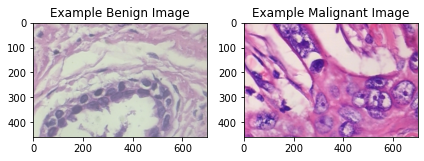

In [12]:
# Define paths to directories
BASE_DIR = "./Breast Cancer DataSet/"
TRAIN_DIR = os.path.join(BASE_DIR, "Train/")
VALID_DIR = os.path.join(BASE_DIR, "valid/")
TEST_DIR = os.path.join(BASE_DIR, "Test/")

def inspect_and_load_data():
    """
    Load and inspect the breast cancer dataset.
    Returns:
        training_images, training_labels: Training images and labels as numpy arrays.
    """
    # Load data (training only, discard test for this step)
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TRAIN_DIR,
        image_size=(150, 150),  # Adjust to uniform size
        batch_size=32,
        label_mode='binary'  # Binary classification: Benign (0), Malignant (1)
    )
    
    # Extract a batch of data for inspection
    for images, labels in train_dataset.take(1):
        training_images = images.numpy()  # Convert to numpy array
        training_labels = labels.numpy()
    
    # Inspect data type and shape
    print(f"training_images is of type {type(training_images)}.\ntraining_labels is of type {type(training_labels)}\n")
    
    data_shape = training_images.shape
    print(f"There are {data_shape[0]} examples with shape ({data_shape[1]}, {data_shape[2]}, {data_shape[3]})")

    return training_images, training_labels

# Execute the function
training_images, training_labels = inspect_and_load_data()


benign_dir = os.path.join(TRAIN_DIR, "Benign")
malignant_dir = os.path.join(TRAIN_DIR, "Malignant")

# Load the first example of a benign image
sample_image_benign = tf.keras.utils.load_img(f"{os.path.join(benign_dir, os.listdir(benign_dir)[0])}")

# Convert the image into its numpy array representation
sample_array_benign = tf.keras.utils.img_to_array(sample_image_benign)

# Print the details for the benign image
print(f"Benign image shape: {sample_array_benign.shape}")
print(f"Maximum pixel value in benign image: {np.max(sample_array_benign)}")

# Load the first example of a malignant image
sample_image_malignant = tf.keras.utils.load_img(f"{os.path.join(malignant_dir, os.listdir(malignant_dir)[0])}")

# Convert the image into its numpy array representation
sample_array_malignant = tf.keras.utils.img_to_array(sample_image_malignant)

# Print the details for the malignant image
print(f"Malignant image shape: {sample_array_malignant.shape}")
print(f"Maximum pixel value in malignant image: {np.max(sample_array_malignant)}")

# Display Images
fig, axs = plt.subplots(1, 2, figsize=(6, 6))
axs[0].imshow(tf.keras.utils.load_img(f"{os.path.join(benign_dir, os.listdir(benign_dir)[0])}"))
axs[0].set_title('Example Benign Image')

axs[1].imshow(tf.keras.utils.load_img(f"{os.path.join(malignant_dir, os.listdir(malignant_dir)[0])}"))
axs[1].set_title('Example Malignant Image')

plt.tight_layout()


In [13]:
def reshape_and_normalize(images):
    """
    Reshapes the array of images and normalizes pixel values.
    
    Args:
        images (numpy.ndarray): The images encoded as numpy arrays.
        
    Returns:
        numpy.ndarray: The reshaped and normalized images.
    """
    # Reshape the images to add an extra dimension at the rightmost side of the array
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)
    
    # Normalize pixel values by dividing by the maximum pixel value (255)
    images = images / 255.0
    
    return images

# TESTING THE FUNCTION
(train_images, _), _ = tf.keras.datasets.mnist.load_data()

# Apply the function
training_images = reshape_and_normalize(train_images)

# Inspect results
print(f"Maximum pixel value after normalization: {np.max(training_images)}\n")
print(f"Shape of training set after reshaping: {training_images.shape}\n")
print(f"Shape of one image after reshaping: {training_images[0].shape}")



Maximum pixel value after normalization: 1.0

Shape of training set after reshaping: (60000, 28, 28, 1)

Shape of one image after reshaping: (28, 28, 1)


In [14]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to stop training once accuracy reaches a specified threshold.
    """
    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy is greater or equal to 0.995
        if logs.get('accuracy') >= 0.995:
            # Stop training once the condition is met
            self.model.stop_training = True
            print("\nReached 99.5% accuracy so cancelling training!")


In [15]:
def training_dataset():
    """Creates the training dataset out of the training images. Pixel values should be normalized.

    Returns:
        tf.data.Dataset: The dataset including the images of benign and malignant faces.
    """
    # Here we use the 'train' directory containing 'benign' and 'malignant' subdirectories
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=os.path.join(BASE_DIR, 'train'),
        image_size=(150, 150),   # Resize all images to 150x150
        batch_size=10,           # Set batch size to 10
        label_mode='binary'      # Since we have two classes (Benign and Malignant)
    )

    # Define the rescaling layer (normalize pixel values to the range [0, 1])
    rescale_layer = tf.keras.layers.Rescaling(1./255)

    # Apply the rescaling using the map method to scale images
    train_dataset_scaled = train_dataset.map(lambda x, y: (rescale_layer(x), y))

    return train_dataset_scaled


In [16]:
train_dataset_scaled = training_dataset()

# Check the shape of the batches
for images, labels in train_dataset_scaled.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")


Found 808 files belonging to 2 classes.
Image batch shape: (10, 150, 150, 3)
Labels batch shape: (10, 1)


In [17]:
def convolutional_model():
    """Returns the compiled (but untrained) convolutional model.

    Returns:
        tf.keras.Model: The model which should implement convolutions.
    """

    # Define the model
    model = tf.keras.models.Sequential([ 
        # First convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        
        # MaxPooling layer to reduce dimensionality
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Second convolutional layer with 64 filters and ReLU activation
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        
        # MaxPooling layer
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Third convolutional layer with 128 filters and ReLU activation
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        
        # MaxPooling layer
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Flatten the 2D data into 1D vector
        tf.keras.layers.Flatten(),
        
        # Dense layer with 128 neurons and ReLU activation
        tf.keras.layers.Dense(128, activation='relu'),
        
        # Output layer with 1 neuron and sigmoid activation for binary classification
        tf.keras.layers.Dense(1, activation='sigmoid')  # Single output for binary classification
    ]) 

    # Compile the model with Adam optimizer and binary cross-entropy loss
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # Use binary cross-entropy for binary classification
        metrics=['accuracy']
    )
          
    return model



In [18]:
# Create the model
model = convolutional_model()

# Print the model summary to inspect the layers
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [19]:
# Load the training dataset
train_dataset_scaled = training_dataset()

# Train the model
history = model.fit(
    train_dataset_scaled,
    epochs=15,
    callbacks=[EarlyStoppingCallback()]
)


Found 808 files belonging to 2 classes.
Epoch 1/15
81/81 [==============================] - 17s 198ms/step - loss: 0.6339 - accuracy: 0.7215
Epoch 2/15
81/81 [==============================] - 16s 200ms/step - loss: 0.5238 - accuracy: 0.7500
Epoch 3/15
81/81 [==============================] - 17s 203ms/step - loss: 0.6636 - accuracy: 0.6658
Epoch 4/15
81/81 [==============================] - 17s 205ms/step - loss: 0.5051 - accuracy: 0.7809
Epoch 5/15
81/81 [==============================] - 17s 208ms/step - loss: 0.4302 - accuracy: 0.8144
Epoch 6/15
81/81 [==============================] - 18s 213ms/step - loss: 0.4128 - accuracy: 0.8230
Epoch 7/15
81/81 [==============================] - 17s 209ms/step - loss: 0.4291 - accuracy: 0.8131
Epoch 8/15
81/81 [==============================] - 17s 209ms/step - loss: 0.5739 - accuracy: 0.6696
Epoch 9/15
81/81 [==============================] - 18s 217ms/step - loss: 0.4034 - accuracy: 0.8292
Epoch 10/15
81/81 [==============================] 